# Import Section

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/covid_project/graph_files'
w2v = '/content/drive/My Drive/covid_project/word2vec'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import csv

Instructions for updating:
non-resource variables are not supported in the long term


# Loading data

In [6]:
import csv
tweet_list = []
filename = w2v+'/tweets_rows_deleted.csv'
with open(filename, 'r', encoding='utf-8') as inp:
  for row in csv.reader(inp):
    tweet_list.append(row[0])
print(tweet_list[:10])

[' italian compares obituaries local daily newspaper one feb mar ', ' like stay home chill weeks good time sickie ', ' happy answer join challenge ', ' challenge ', ' important changes hse guidance ', ' italian air force encouraging italians fight pandemic pavarotti singing win ', ' italy affected country outside china cases deaths ', ' seeing accounts companies laying people there sadly buisness casualties there silently failing companies perfect chance lay teams close doors blame external ', ' refined strategy really call real name sacrifice strategy govt resources brexit past year conduct ', ' this hard fuck ']


In [7]:
corpus = []
for elem in tweet_list:
  l = elem.split()
  for el in l:
    corpus.append(el)
print(corpus[:10])

['italian', 'compares', 'obituaries', 'local', 'daily', 'newspaper', 'one', 'feb', 'mar', 'like']


# Building dataset

In [8]:
vocabulary_size = 50000

def build_dataset(words):
  count = [('UNK', 0)]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  
  for word in words:
    
    index = dictionary[word]
    data.append(index)
  
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(corpus)
data_size = len(reverse_dictionary.keys())
print('data: ',data[:10])
print('Count: ', count[:10])
#print('dictionary: ', dictionary)
#print('Reverse: ', reverse_dictionary)

data:  [399, 5320, 7620, 188, 198, 3518, 135, 917, 567, 13]
Count:  [('UNK', 0), ('amp', 5291), ('the', 5129), ('people', 4361), ('this', 3711), ('cases', 3162), ('health', 2582), ('coronavirus', 2289), ('new', 2229), ('you', 1900)]


In [9]:
del corpus  # Hint to reduce memory.
print('Most common words ', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words  [('amp', 5291), ('the', 5129), ('people', 4361), ('this', 3711), ('cases', 3162)]
Sample data [399, 5320, 7620, 188, 198, 3518, 135, 917, 567, 13] ['italian', 'compares', 'obituaries', 'local', 'daily', 'newspaper', 'one', 'feb', 'mar', 'like']


# Building and training model

In [10]:
BATCH_SIZE = 1000
EPOCHS = 20
EMBEDDING_SIZE = 100  # Dimension of the embedding vector.
SKIP_WINDOW = 2       # How many words to consider left and right.
NUM_SKIPS = 2         # How many times to reuse an input to generate a label.

WINDOW_SIZE = 10
VALID_SIZE = 16     # Random set of words to evaluate similarity on.
VALID_WINDOW = 100  # Only pick dev samples in the head of the distribution.
#valid_examples = np.random.choice(VALID_WINDOW, VALID_SIZE, replace=False)
NUM_SAMPLED = 64    # Number of negative examples to sample.
EXP_WORDS = WINDOW_SIZE *2
ITERATIONS = 5

In [11]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(data)
total_count = len(data)
freqs = {word: number/total_count for word, number in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in data if random.random() < (1 - p_drop[word])]

In [12]:
# Get a list of words in a window around an index.
def get_target(words, idx, window_size=5):
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [13]:
# Create a generator of word batches as a tuple (inputs, targets) 
def get_batches(words, batch_size, window_size=5):

    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [14]:
graph = tf.Graph()

with graph.as_default():

  # input tensors
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_input') #BATCH_SIZE
    train_labels = tf.placeholder(tf.int32, shape=[None, None], name='train_labels') #BATCH_SIZE, EXP_WORDS
  
  
  # variable tensors
  with tf.name_scope('variables'):
    word_embeddings = tf.Variable(tf.random_uniform([data_size, EMBEDDING_SIZE], -1.0, 1.0), name='word_embeddings')
    context_embeddings = tf.Variable(tf.truncated_normal([data_size, EMBEDDING_SIZE],stddev=1.0 / math.sqrt(EMBEDDING_SIZE)), name='context_embeddings')
    out_biases = tf.Variable(tf.zeros([data_size]))
  
  lookup = tf.nn.embedding_lookup(word_embeddings, train_inputs) # forward inputs to the hidden layer

  # loss
  with tf.name_scope('cost'):
      softmax = tf.nn.sampled_softmax_loss(
        weights=context_embeddings,
        biases=out_biases,
        labels=train_labels,
        inputs=lookup,
        num_classes=data_size,
        num_sampled=NUM_SAMPLED,
        num_true=1
      )
      cost = tf.reduce_mean(softmax, name='reduce_mean')

  # track the batch loss in the summary
  tf.summary.scalar('cost', cost)
  # optimizer
  with tf.name_scope('optimizer'):
      optimizer = tf.train.AdamOptimizer().minimize(cost)

  with tf.name_scope('validation'):
    # pick random words to analize in range (1,30) 
    #or to pick 8 random words from range (1,30) and from (100,1000)
    #use the commented part of next line and remove # from the sequent line
    valid_examples = np.array(random.sample(range(1,30), VALID_SIZE))# np.array(random.sample(range(1,30), VALID_SIZE//2))
    #valid_examples = np.append(valid_examples, random.sample(range(100,1000), VALID_SIZE//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_mean(tf.square(word_embeddings), 1, keepdims=True))
    normalized_embedding = word_embeddings / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))


  merged = tf.summary.merge_all() # merged summaries
  init = tf.global_variables_initializer() # variables initializer
  saver = tf.train.Saver() # network saver
print('>> graph created') 

>> graph created


In [15]:
def matrix_to_txt(matrix, directory):
  with open(directory, 'w', encoding='utf-8') as txt:
        for row in matrix:
            for j in range(len(row)):
                print(row[j], file=txt, end=' ')

def vector_to_txt(vector, directory):
  with open(directory, 'w', encoding='utf-8') as txt:
        for value in vector:
            print(value, file=txt)

In [26]:
import time
with tf.Session(graph=graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    for _ in range(1,ITERATIONS+1):
      for e in range(1, EPOCHS+1):
          batches = get_batches(train_words, BATCH_SIZE, WINDOW_SIZE)
          #start = time.time()
          for x, y in batches:
              
              feed = {train_inputs: x,
                      train_labels: np.array(y)[:, None]}
              train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
              
              loss += train_loss
              '''
              if iteration % 100 == 0: 
                  end = time.time()
                  print("Epoch {}/{}".format(e, EPOCHS),
                        "Iteration: {}".format(iteration),
                        "Avg. Training loss: {:.4f}".format(loss/100),
                        "{:.4f} sec/batch".format((end-start)/100))
                  loss = 0
                  start = time.time()
              '''
              if iteration % 1000 == 0:
                  sim = similarity.eval()

                  embeddings = sess.run(word_embeddings)

                  for i in range(VALID_SIZE):
                      valid_word = reverse_dictionary[valid_examples[i]]
                      top_k = 8 # number of nearest neighbors
                      nearest = (-sim[i, :]).argsort()[1:top_k+1]
                      log = 'Nearest to %s:' % valid_word
                      for k in range(top_k):
                          close_word = reverse_dictionary[nearest[k]]
                          log = '%s %s,' % (log, close_word)
                      print(log)
                  # save the weights
                  directory = w2v+'/checkpoint/'
                  matrix_to_txt(embeddings, os.path.join(directory, 'word-embeddings.ls'))
                  matrix_to_txt(sess.run(context_embeddings), os.path.join(directory, 'context-embeddings.ls'))
                  vector_to_txt(sess.run(out_biases), os.path.join(directory,'biases.ls'))

                  saver.save(sess, os.path.join(directory, 'model.ckpt'))
              iteration += 1
            
          print("Epoch {}/{}".format(e, EPOCHS),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100))
          loss = 0

      #file = os.path.join(w2v, '/checkpoint/checkpoint.ckpt')
      #save_path = saver.save(sess, file)

      embed_mat = sess.run(normalized_embedding)

Epoch 1/20 Iteration: 158 Avg. Training loss: 7.2262
Epoch 2/20 Iteration: 315 Avg. Training loss: 7.1437
Epoch 3/20 Iteration: 472 Avg. Training loss: 7.0667
Epoch 4/20 Iteration: 629 Avg. Training loss: 6.9788
Epoch 5/20 Iteration: 786 Avg. Training loss: 6.8703
Epoch 6/20 Iteration: 943 Avg. Training loss: 6.7292
Nearest to home: otra, intergenerational, retreat, defining, survivable, bushehr, rehearsal, clerk,
Nearest to world: sep, lazio, narrowing, baggage, optics, kills, moderates, taxies,
Nearest to know: someones, ecosystem, realidad, adopters, violation, effortsfor, compared, jacket,
Nearest to need: disgusting, traditional, tangibly, windhoek, hink, karn, knock, dope,
Nearest to people: policemen, takedowns, needless, mistep, initiate, disgruntled, construy, zhu,
Nearest to pandemic: estemos, arrggggg, classifies, hablar, sukkur, mourning, batalla, injustice,
Nearest to now: antara, airman, cribbing, animals, began, logarithmic, muertos, neglects,
Nearest to public: genie, t

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [28]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

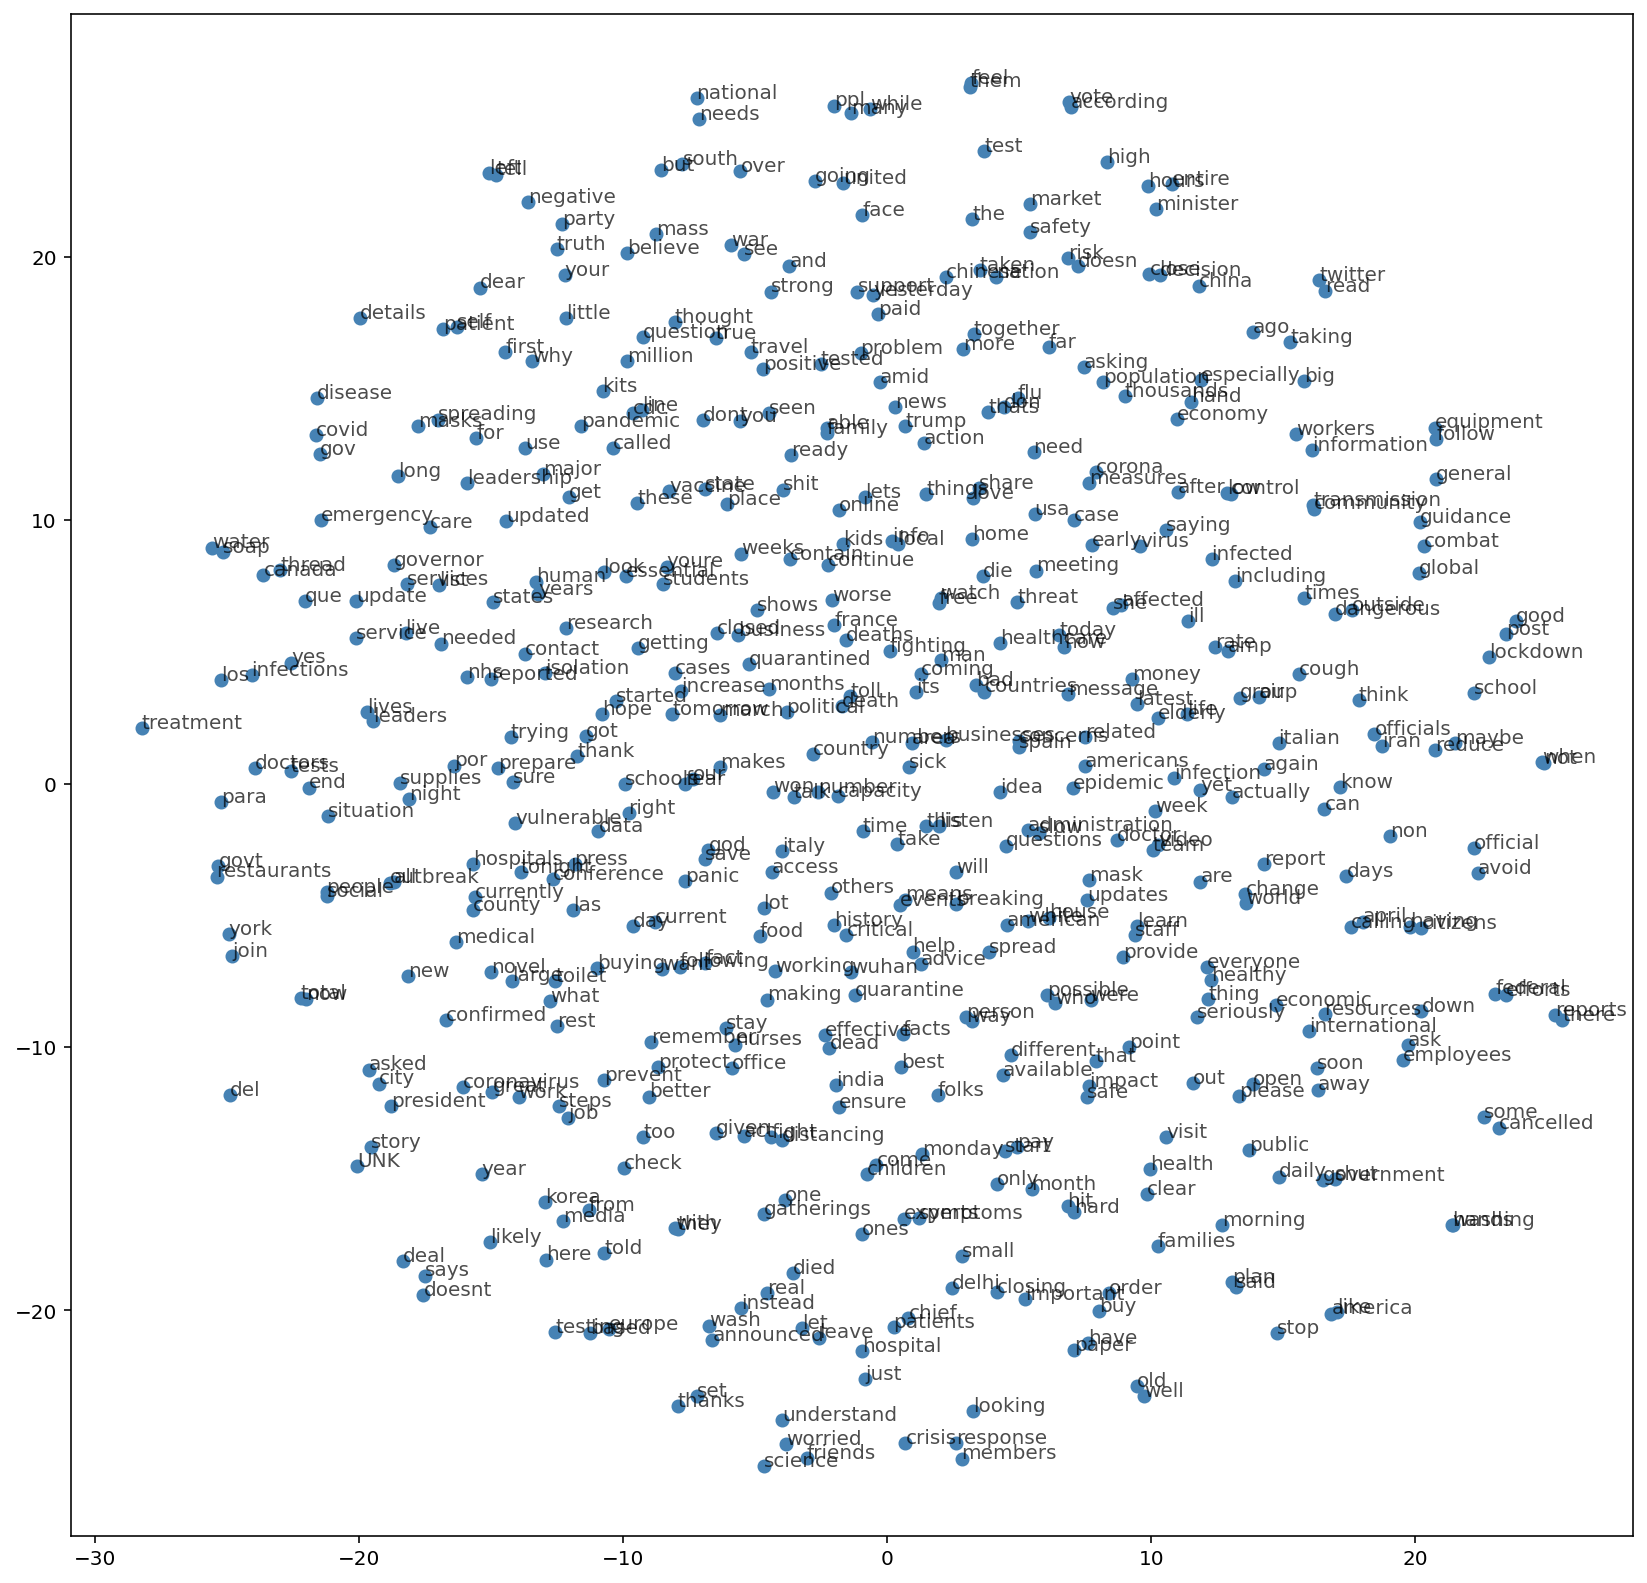

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(reverse_dictionary[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)